# 12-8. 프로젝트: 나랑 닮은 연예인을 찾아보자

* ```face_recognition``` 모듈을 사용해 사진에서 얼굴 영역을 인식해 crop한 후, crop한 얼굴 영역의 임베딩 벡터를 구하는 함수를 만들었다.   
   
   
* 내 얼굴 사진 2장과, 연예인 사진 200여장을 모두 임베딩한 후 각각 L2 distance를 계산해 가장 닮은꼴을 찾았다.   
   
   
* 내 얼굴끼리 L2 distance를 비교해보니 **0.4214110448245491**로 가까운 편이었다.   
   
   
* 상위 10명을 프린트한 결과는 아래와 같았다. 두 번째 내 사진의 경우 가장 닮은꼴이 첫 번째 내 사진이 아니라 다른 연예인이 나오기도 했다.   
   
   
* 이영빈 님이 공유해주신 이미지에 '조승우'와 '조승우 낚시짤'(아래) 을 숨겨뒀으나 (다행히도) 후자는 상위 닮은꼴에 등장하지 않았다.   
   
   
* 응용으로 tkinter 를 활용한 닮은꼴 찾기 애플리케이션을 만들었다. 이미지를 업로드하면, 200명의 유명인 사진 중 닮은꼴을 찾아주는 기능을 갖췄다. 다만 현존하는 코드와 인프라로는 임베딩 시간이 오래 걸려 실제 사용 가능한 프로그램이라고 보긴 어려울 것 같다.

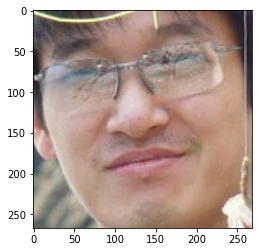

In [10]:
# 숨겨둔 함정 카드!
hidden = get_cropped_face('images/조승우낚시짤.jpg')
plt.imshow(hidden)

## 필요한 모듈 import

In [1]:
import face_recognition
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tkinter import *
import tkinter.ttk as ttk
from tkinter import filedialog # https://stackoverrun.com/ko/q/7853033
# import tkinter.messagebox as tmb
from PIL import Image

## 사진 모으기
* 이영빈님이 slack에 공유해주신 유명인 이미지 파일 200여장을 활용했다.

## 얼굴 영역 자르기
* get_gropped_face(image_file)
* 자른 이미지는 PIL의 Image.fromarray를 통해서 PIL Image로 변환한 뒤에 저장을 해두면 다양한 재미있는 시각화를 시도해 보는데 도움이 될 것입니다.

In [2]:
def get_cropped_face(image_file_path):
    image = face_recognition.load_image_file(image_file_path)
    face_locations = face_recognition.face_locations(image) # width start, height end, width end, height start 순 [(98, 758, 284, 572)]
    
    a, b, c, d = face_locations[0] # 한 사람만 있는 이미지들을 사용할 것이기 때문에 0밖에 없음
    cropped_face = image[a:c, d:b, :]
    
    return cropped_face

## 얼굴 영역의 임베딩 추출하기
* def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
* def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

In [3]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)[0]

def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for idx, file in enumerate(file_list):
        # print('current_file: ' + str(file) + ' (' + str(idx+1) + '/' + str(len(file_list)) + ')')
        curr_person_name = file.split('.')[0]
        
        if not dir_path.endswith('/'):
            curr_dir_path = dir_path + '/'
        else:
            curr_dir_path = dir_path
        
        curr_embedding = face_recognition.face_encodings(get_cropped_face(curr_dir_path + file))
        # print(curr_person_name + ': ' + str(curr_embedding))
        
        if len(curr_embedding) > 0:  # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[curr_person_name] = curr_embedding[0]
        else:
            embedding_dict[curr_person_name] = curr_embedding
    
    return embedding_dict

## 내 사진끼리 비교해보기

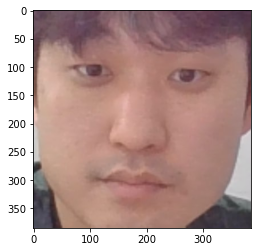

In [4]:
# 내 사진 1: crop 후 출력
me1 = get_cropped_face('images/jonggu1.jpg')
plt.imshow(me1)

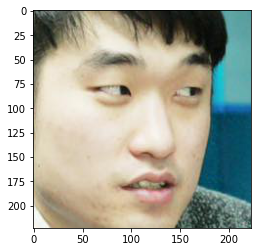

In [5]:
# 내 사진 2: crop 후 출력
me2 = get_cropped_face('images/jonggu2.jpg')
plt.imshow(me2)

In [6]:
me1_embedding = get_face_embedding(me1)
me2_embedding = get_face_embedding(me2)

print(np.linalg.norm(me1_embedding-me2_embedding, ord=2)) # 내 얼굴 사이의 L2 distance

0.4214110448245491


## 모은 연예인들과 비교하기

In [7]:
embedding_dict = get_face_embedding_dict('images')

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2) # L2 distance

def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1


def get_nearest_face(name, top=10):
    sort_key_func = get_sort_key_func(name)
    
    result = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(1, top):
        if i == 0:
            continue
        else:
            print('순위 {} : 이름({}), 거리({})'.format(i, result[i][0], sort_key_func(result[i][0])))

In [8]:
get_nearest_face('jonggu1', 11)

순위 1 : 이름(jonggu2), 거리(0.4214110448245491)
순위 2 : 이름(류준열), 거리(0.4299905785966888)
순위 3 : 이름(배성우), 거리(0.4355719939598728)
순위 4 : 이름(김민재), 거리(0.4443702959299478)
순위 5 : 이름(조승우), 거리(0.4516158421462406)
순위 6 : 이름(이희준), 거리(0.4516660554739425)
순위 7 : 이름(배성재), 거리(0.4545264179132258)
순위 8 : 이름(최준석), 거리(0.45688041010912617)
순위 9 : 이름(윤균상), 거리(0.45713273868834803)
순위 10 : 이름(손호준), 거리(0.46157872478997963)


In [9]:
get_nearest_face('jonggu2', 11)

순위 1 : 이름(이희준), 거리(0.41235143673419733)
순위 2 : 이름(jonggu1), 거리(0.4214110448245491)
순위 3 : 이름(개리), 거리(0.43133835403747484)
순위 4 : 이름(조승우), 거리(0.44823801119181744)
순위 5 : 이름(조원희), 거리(0.4483831263105048)
순위 6 : 이름(정수빈), 거리(0.4618006699354936)
순위 7 : 이름(정국), 거리(0.46264431587077703)
순위 8 : 이름(이대형), 거리(0.464421436772069)
순위 9 : 이름(이용진), 거리(0.46602823301432345)
순위 10 : 이름(이근대위), 거리(0.46946991590514664)


In [ ]:
window = Tk()
window.title("나와 닮은꼴 찾기")
window.geometry("1024x512")

def image_upload(name): # https://stackoverflow.com/questions/17709195/import-image-into-tkinter
    filename = filedialog.askopenfilename()
    # print(filename)
    print('입력된 이름: ' + name)
    
    if name == None or name == "":
        curr_name = "이름없음"
    else:
        curr_name = name
        
    img = Image.open(filename)
    curr_filetype = filename.split('.')[len(filename.split('.'))-1]
    print("current filetype: " + curr_filetype)
    img.save('images/' + curr_name + '.' + curr_filetype)
    
def submit(name):
    print("전달된 이름: " + name)
    
    label_loading1 = ttk.Label(window, text="유명인 이미지를 불러오는 중입니다. 잠시만 기다려주세요.")
    label_loading1.grid(row=0, column=2)
    
    embedding_dict = get_face_embedding_dict('images')
    
    curr_image = get_cropped_face('images/' + name + '.jpg')
    curr_image_embedding = get_face_embedding(curr_image)
    embedding_dict[name] = np.array(curr_image_embedding)
    
    result = get_nearest_face(name, 11)
    
    print(result)
    
    label_loading1.after(1, label_loading1.master.destroy)
    label_loading2.after(1, label_loading2.master.destroy)
    
    label_result = ttk.Label(window, text=str(result))
    label_result.grid(row=0, column=2)
    

label_name = ttk.Label(window, text="이름부터 입력해주세요.")
input_name = ttk.Entry(window)

label_before = ttk.Label(window, text="사진 업로드")
button_upload = ttk.Button(window, text="사진 업로드", command=lambda:image_upload(input_name.get()))
button_submit = ttk.Button(window, text="찾기!", command=lambda:submit(input_name.get()))

label_name.grid(row=0, column=0)
input_name.grid(row=1, column=0)

label_before.grid(row=0, column=1)
button_upload.grid(row=1, column=1)
button_submit.grid(row=2, column=1)

window.mainloop()
print("완료!")